In [1]:
suppressPackageStartupMessages(
    {suppressWarnings({
        library(tidyverse)
        library(repr)
        library(tidymodels)
        library(GGally)
        library(gridExtra)
        library(grid)
        library(tidyr)
    })
})
    

In [2]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.matrix.max.rows = 7,readr.show_col_types = FALSE)

player_data <- read_csv("data/players.csv")
session_data <- read_csv("data/sessions.csv")



In [3]:
ply_summarised_num <- player_data |>
                summarise(subscribed_percent_decimal = mean(subscribe),
                       played_hours_avg = mean(played_hours),
                       played_hours_median = median(played_hours),
                       played_hours_max = max(played_hours),
                       played_hours_min = min(played_hours),
                       age_avg =  mean(Age, na.rm = TRUE), 
                       age_median = median(Age, na.rm = TRUE),
                       age_max = max(Age,  na.rm = TRUE), 
                        age_min = min(Age,  na.rm = TRUE)) |>
                        select(subscribed_percent_decimal,played_hours_avg,played_hours_median, played_hours_max, played_hours_min,age_avg,age_median, age_max, ) |>
                        round(2)

ply_summarised_gender <- player_data |>
                        select(gender) |>
                        count(gender) |>
                        mutate(percent_decimal = round(n /sum(n), 2)) |>
                        rename(count = n)

ply_summarised_experience <- player_data |>
                        select(experience) |>
                        count(experience) |>
                        mutate(percent_decimal = round(n /sum(n), 2)) |>
                        rename(count = n)


# **Data Science Project: Planning Stage**

## **(1) Data Description:**
Samples were collected from the plaicraft.ai website through volunteer sign-up, where participants provided their email addresses, phone numbers, and personal details to participate.

#### **Player Data:** 
Observations: 196 

Variables: 7 

  - `experience` \<char> player gaming experience, `Beginner`, `Amateur`, `Regular`, `Veteran`, `Pro`.
  - `subscribe` \<Boolean> newsletter subscription status, `TRUE` or `FALSE`.
  - `hashedEmail` \<char> unique player data ID.
  - `played_hours` \<double> total hours spent playing on server.
  - `name` \<char> player first name.
  - `gender` \<char> gender identifier, `Male`, `Female`, `Non-binary`, `Prefer not to say`, `Agender`, `Two-Spirited`, `Other`.
  - `Age` \<double> age in years.

#### General Stats:

In [4]:
ply_summarised_num

subscribed_percent_decimal,played_hours_avg,played_hours_median,played_hours_max,played_hours_min,age_avg,age_median,age_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.73,5.85,0.1,223.1,0,21.14,19,58


#### Gender Stats:

In [5]:
ply_summarised_gender

gender,count,percent_decimal
<chr>,<int>,<dbl>
Agender,2,0.01
Female,37,0.19
Male,124,0.63
Non-binary,15,0.08
Other,1,0.01
Prefer not to say,11,0.06
Two-Spirited,6,0.03


#### Experience Stats:

In [6]:
ply_summarised_experience

experience,count,percent_decimal
<chr>,<int>,<dbl>
Amateur,63,0.32
Beginner,35,0.18
Pro,14,0.07
Regular,36,0.18
Veteran,48,0.24


#### Potential Issues:
- Missing values in `Age`.
- Players with 0 `played_hours` and dominant male-identifying participants could skew results.
- Risk of volunteer bias.

In [7]:
distinct_players <- session_data |>
                    select(hashedEmail) |>
                    n_distinct()
total_visits <- session_data |>
                nrow()
players_count <- session_data |>
                        select(hashedEmail) |>
                        count(hashedEmail) |>
                        rename(count = n) |>
                        select(count) 

player_single_visit <-  players_count |> 
                            select(count) |> 
                            filter(count == 1) |>
                            nrow()
                        

session_stats <- players_count |>
                summarise(
                    count_player_max_visits = max(count),
                    count_player_min_visits = min(count)
                ) |>
                mutate(distinct_players = distinct_players, 
                       num_player_single_visit = player_single_visit, total_visits = total_visits) |>
                select(total_visits, distinct_players, 
                       num_player_single_visit, count_player_max_visits, 
                       count_player_min_visits)



#### **Session Data:**
Observations: 1535 

Variables: 5 
- `hashedEmail` \<char> unique hash data ID per player.
  
Sessions:
- `start_time` \<char> start date and military time.
- `end_time` \<char> end date and military time.
- `original_start_time` \<char> precise start time (milliseconds).
- `original_end_time` \<char> precise end time (milliseconds).


#### Session Stats:

In [8]:
session_stats

total_visits,distinct_players,num_player_single_visit,count_player_max_visits,count_player_min_visits
<int>,<int>,<int>,<int>,<int>
1535,125,81,310,1


#### Potential Issues:
- Single cell date/time variable complicates analysis.
- All variables are in char, conversion required for numerical analysis.
- Only 125 of 196 players have session data, which may skew results from `played_hours`.

### **(2) Questions:**
Q1: Which player characteristics and behaviours best predict subscription to a game-related newsletter, and how do these differ among player types?

What players' `Age`, `gender`, and `played_hours` can best predict whether they would `subscribe` to a gaming newsletter, and how does it differ from players `experience`?


Using bucketed Age and gender variables will help isolate player characteristics that result in most likely subscription. Participants `play_hours`, see how time spent playing on the server correlates with subscribing. We can further evaluate how these resulting subscriptions from characteristics and behaviours behave based on their gaming `experience`.

### **(3) Exploratory Data Analysis and Visualization:**

gender,experience,Age,played_hours,subscribe
<chr>,<chr>,<dbl>,<dbl>,<lgl>
Male,Pro,9,30.3,TRUE
Male,Veteran,17,3.8,TRUE
Male,Veteran,17,0.0,FALSE
Female,Amateur,21,0.7,TRUE
⋮,⋮,⋮,⋮,⋮
Male,Veteran,22,0.3,FALSE
Prefer not to say,Amateur,57,0.0,FALSE
Male,Amateur,17,2.3,FALSE


player_hours_mean,player_age_mean
<dbl>,<dbl>
5.9,21.14


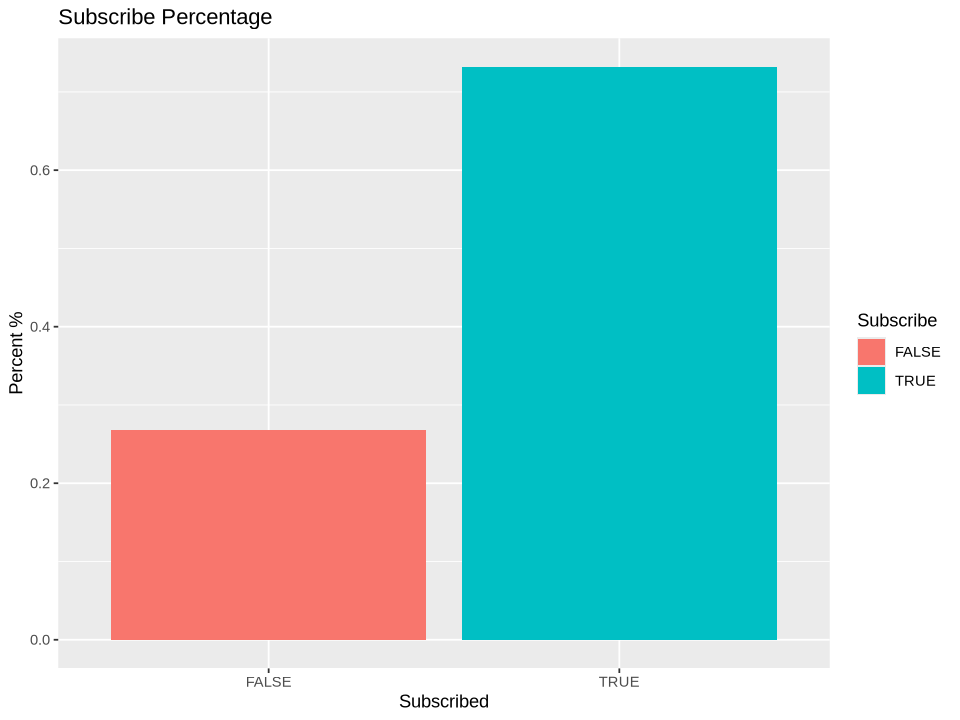

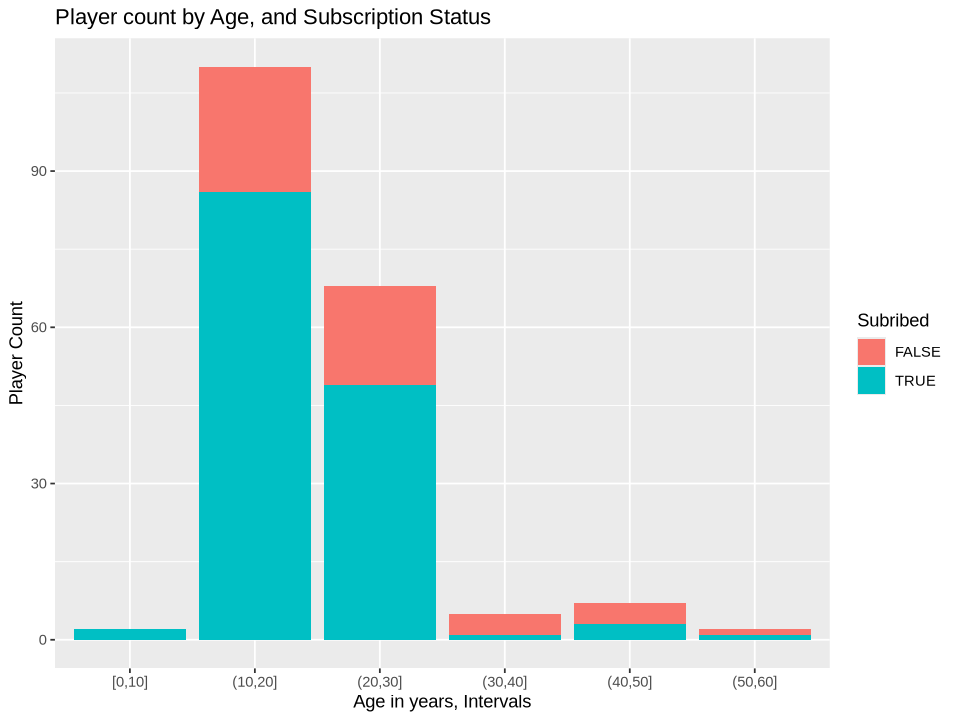

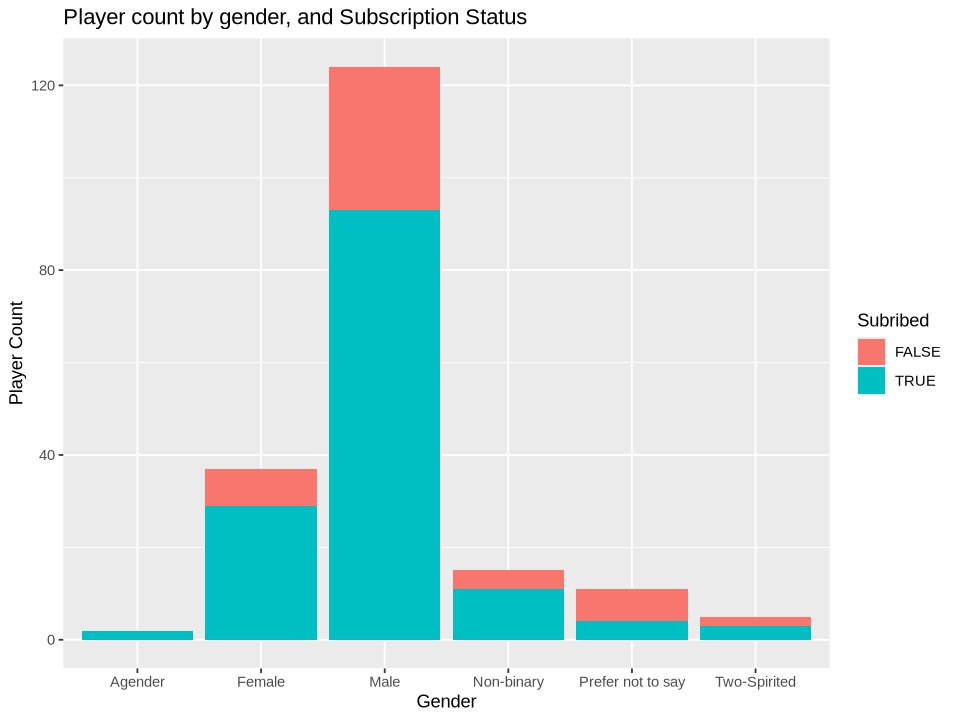

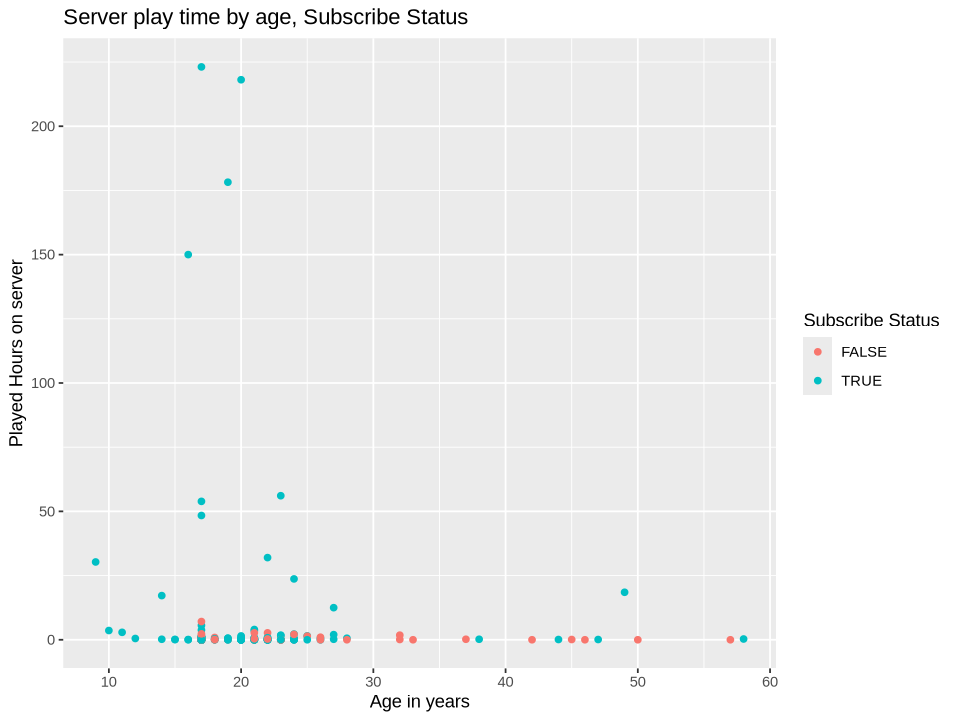

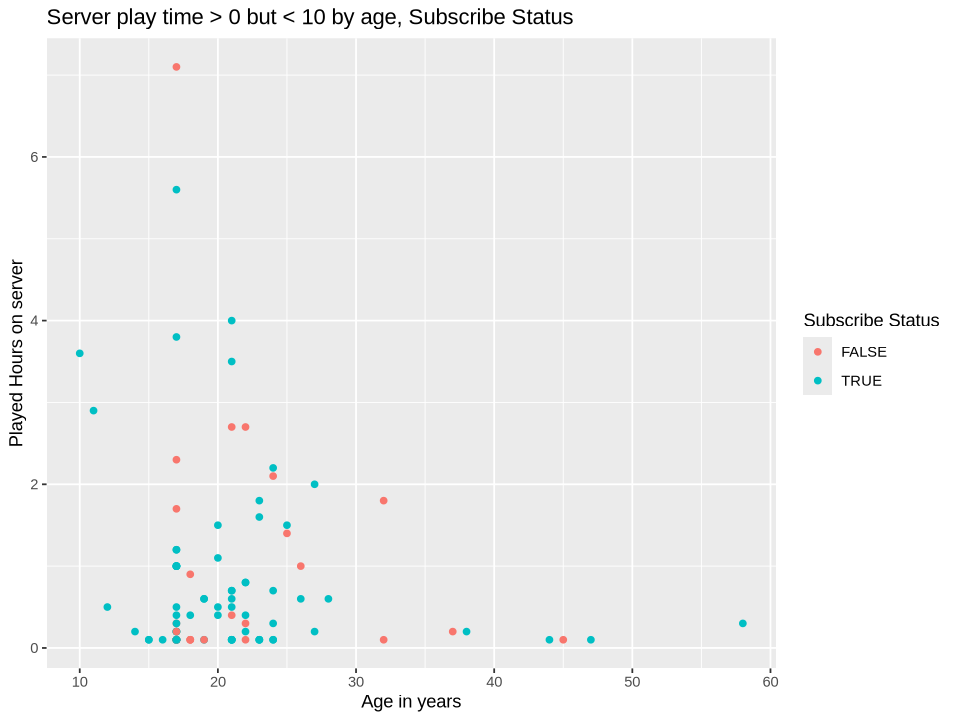

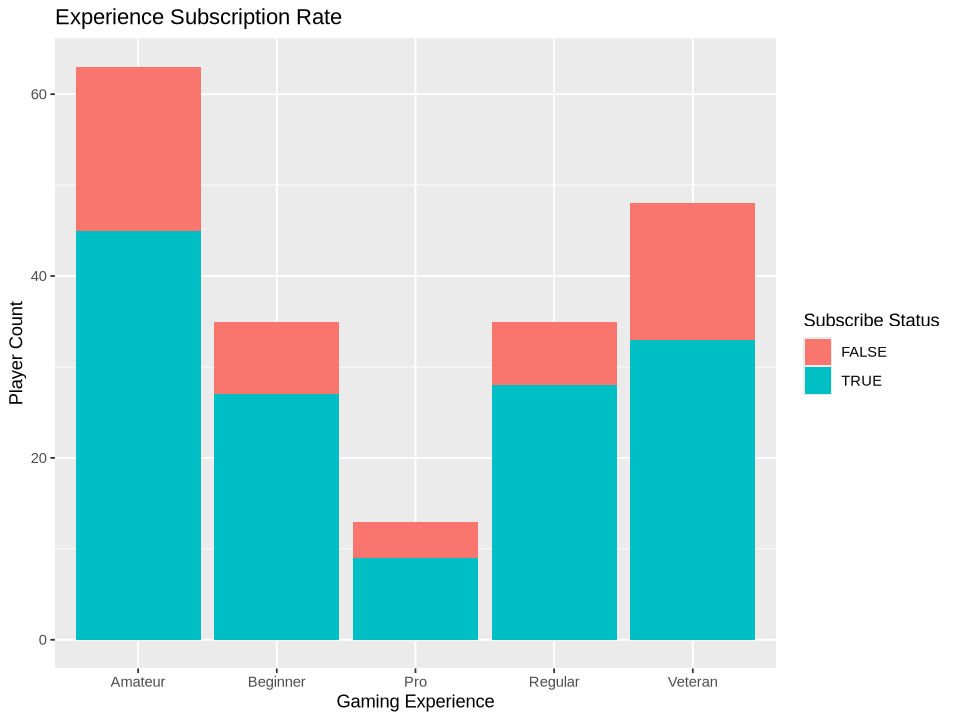

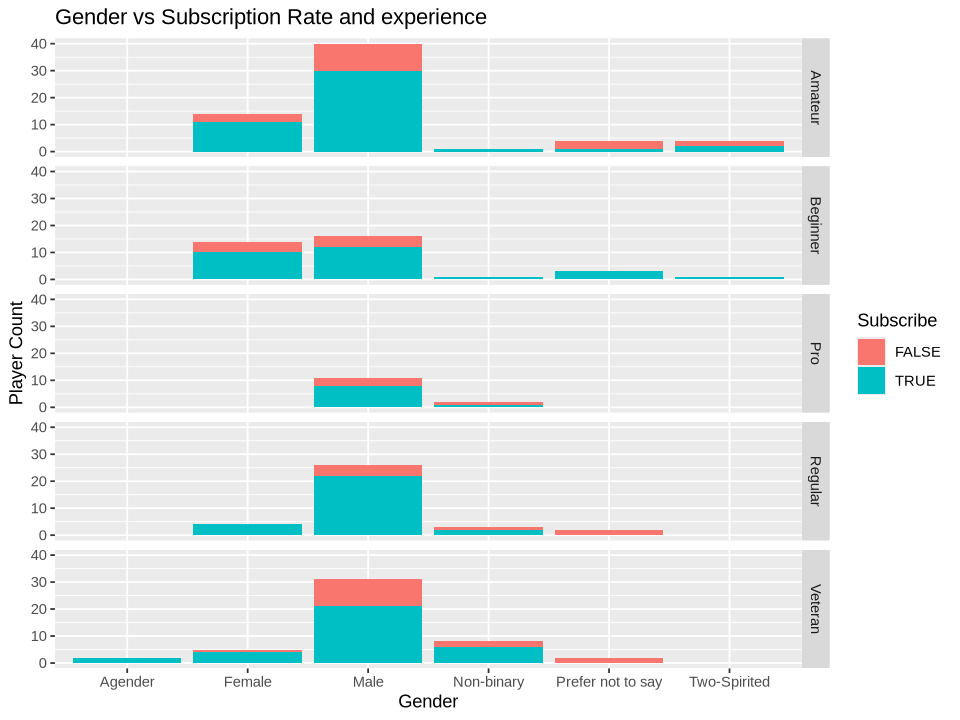

In [9]:
options(repr.plot.width = 8, repr.plot.height = 6)


# player_data
player_wraggled <- player_data |>
            select(gender, experience, Age, played_hours, subscribe) |>
            drop_na()

player_wraggled

player_means_minimal <- player_wraggled |> 
            select(played_hours, Age) |>
            summarize(player_hours_mean = mean(played_hours), player_age_mean = mean(Age)) |>
            round(2)

player_means_minimal
player_age_buckets <- player_wraggled |>
                mutate(age_intervel = cut_interval(Age, length = 10)) 

sub_count <- player_age_buckets |>
            count(subscribe, age_intervel) 

perc_sub <- player_wraggled |>
            count(subscribe) |>
            mutate(sub_pct= (pct = n / sum(n))) 
# perc_sub
###### VISUALS ###########
true_false_bar_sub <- perc_sub |>
            ggplot(aes(x=subscribe , y = sub_pct, fill = subscribe)) + 
            geom_col() +
            ggtitle("Subscribe Percentage") + 
            labs(x = "Subscribed", y = "Percent %", fill = "Subscribe")
            
true_false_bar_sub

sub_age_bar <- sub_count |>
            ggplot(aes( x = age_intervel , y = n, fill = subscribe)) +
            geom_bar(stat = "identity") +
            ggtitle("Player count by Age, and Subscription Status") + 
            labs(x = "Age in years, Intervals", y = "Player Count", fill = "Subribed")

sub_age_bar


gender_age_count <- player_age_buckets |>
                select(subscribe, gender) |>
                 count(subscribe, gender) 

gender_age_bar <- gender_age_count |>
            ggplot(aes( x = gender , y = n, fill = subscribe)) +
            geom_bar(stat = "identity") +
            ggtitle("Player count by gender, and Subscription Status") + 
            labs(x = "Gender", y = "Player Count", fill = "Subribed")      

gender_age_bar

age_hours_sub_point <- player_wraggled |>
                ggplot(aes( x = Age, y= played_hours, colour = subscribe)) + 
                geom_point(stat = "identity") +
                ggtitle("Server play time by age, Subscribe Status") +
                labs(x= "Age in years", y ="Played Hours on server", colour ="Subscribe Status")
age_hours_sub_point

no_zero_age_hours_sub_point <- player_wraggled |>
                filter(played_hours > 0, played_hours < 10) |>
                ggplot(aes( x = Age, y= played_hours, colour = subscribe)) + 
                geom_point(stat = "identity") +
                ggtitle("Server play time > 0 but < 10 by age, Subscribe Status") +
                labs(x= "Age in years", y ="Played Hours on server", colour ="Subscribe Status")
no_zero_age_hours_sub_point


exp_sub_bar <- player_wraggled |>
            ggplot(aes(x = experience, fill = subscribe)) + 
            geom_bar() +
            ggtitle("Experience Subscription Rate") +
            labs(x= "Gaming Experience", y = "Player Count", fill ="Subscribe Status")

exp_sub_bar

facet_exp_hours_sub_gender <- player_wraggled |>
                    ggplot(aes(x=gender, fill =subscribe)) + 
                    geom_bar() +
                    facet_grid(vars(experience)) +
                    ggtitle("Gender vs Subscription Rate and experience") +
                    labs(x = "Gender",  y = "Player Count", fill = "Subscribe")

facet_exp_hours_sub_gender


#### Graph Incite

- The majority of our data comes from males aged 10 to 30, in addition.
- Above 10 hours of play time, our points are all subscribed.
- Agender are all subscribe and Prefer not to say are not.

### **(4) Methods and Plan:**
I would use a k-nearest neighbours classification model to predict `subscribe` label from  `Age`, `gender`, and `played_hours`.

This method is best suited for small datasets for label prediction.

An assumption we need to make with this model is that nearby data points have similar labels

Some limitations of this model are caused by skewed data that is heavily dominated by a category or has a single resulting label. In our data, we have skewed `Age` and `gender` being dominated by a category, while some categories with small sample sizes, like Agender, are all True or all false, which will lead to false positives and negatives if not handled correctly.

I will use k-fold cross-validation on the training data to tune my models and find the best k, and finally use precision metrics to determine the best model based on selected characteristics and behaviour.

I will split the data into 70% for training and 30% for testing. For each column, `Age`, `gender`, and `played_hours` I will build and train their models using k-fold cross-validation. Then, test and compare each column model using precision metrics to determine which model best predicts subscription. 


### (5) GitHub Repository
GitHub Repo: https://github.com/FabianoGLentini/DSCI_100_Planning